In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
import itertools
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

df_limpio = pd.read_csv("Datos/Transformados/limpio.csv", index_col=0)
df_limpio.index = pd.to_datetime(df_limpio.index)
rent_diarias = df_limpio.pct_change()

1º OPCIÓN: Métricas

Resumen de Rentabilidad, Riesgo y Sharpe por Activo:
      Rentabilidad Anualizada  Volatilidad Anualizada  Ratio Sharpe
AAPL                 0.388099                0.339550      1.113528
AMGN                 0.131513                0.273750      0.443884
AXP                  0.237904                0.404536      0.563371
BA                   0.024818                0.564348      0.026258
CAT                  0.162074                0.341471      0.445350


C:\Users\lande\AppData\Local\Temp\ipykernel_7540\993941428.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (resumen_activos['Volatilidad Anualizada'][i], resumen_activos['Rentabilidad Anualizada'][i]),


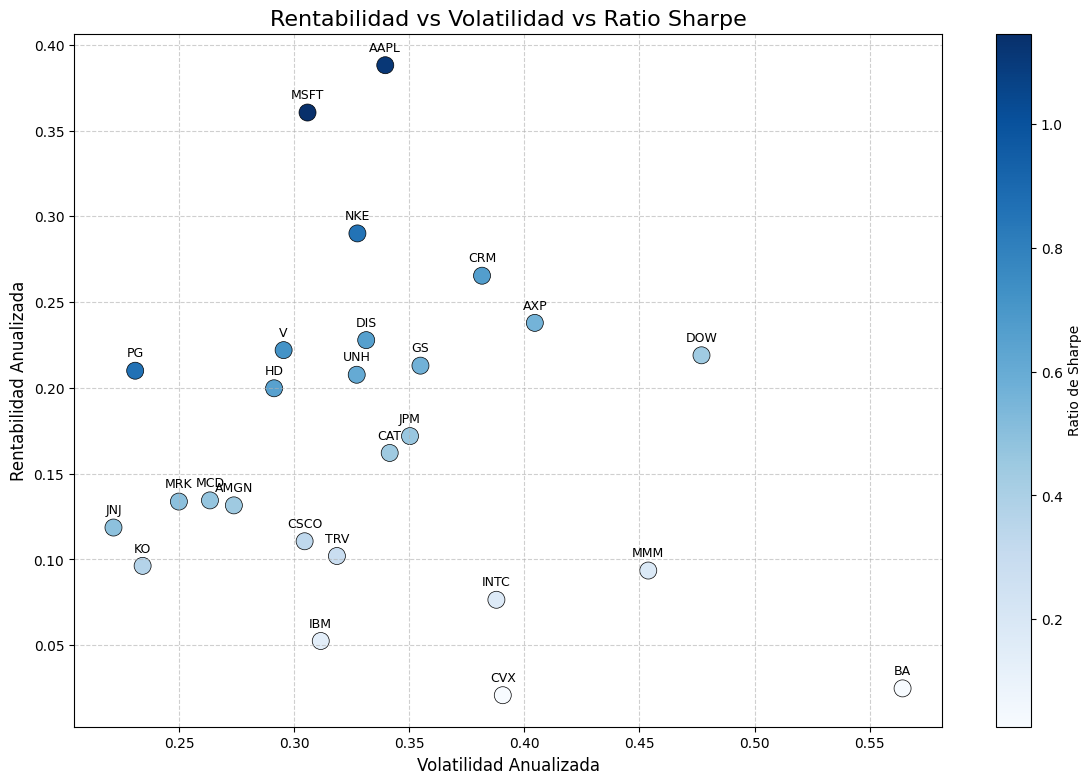

In [2]:
rentabilidad_anualizada = rent_diarias.mean() * 252
volatilidad_anualizada = rent_diarias.std() * np.sqrt(252)
risk_free_rate = 0.01 
resumen_activos = pd.DataFrame({
    'Rentabilidad Anualizada': rentabilidad_anualizada,
    'Volatilidad Anualizada': volatilidad_anualizada})
resumen_activos['Ratio Sharpe'] = (resumen_activos['Rentabilidad Anualizada'] - risk_free_rate) / resumen_activos['Volatilidad Anualizada']
print("Resumen de Rentabilidad, Riesgo y Sharpe por Activo:")
print(resumen_activos.head())
plt.figure(figsize=(14, 9))
scatter = plt.scatter(
    x=resumen_activos['Volatilidad Anualizada'],
    y=resumen_activos['Rentabilidad Anualizada'],
    c=resumen_activos['Ratio Sharpe'], 
    cmap='Blues', s=150,alpha=1,edgecolors='black', linewidths=0.5)
plt.colorbar(scatter, label='Ratio de Sharpe')
plt.title('Rentabilidad vs Volatilidad vs Ratio Sharpe', fontsize=16)
plt.xlabel('Volatilidad Anualizada', fontsize=12)
plt.ylabel('Rentabilidad Anualizada', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
for i, txt in enumerate(resumen_activos.index):
    plt.annotate(txt, (resumen_activos['Volatilidad Anualizada'][i], resumen_activos['Rentabilidad Anualizada'][i]),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
plt.show()

In [3]:
def cartera_simple(df_precios, risk_free_rate=0.0):
    returns = df_precios.pct_change().dropna()
    cov_anual = returns.cov() * 252
    resultados = []
    combinaciones = list(itertools.combinations(df_precios.columns, 3))
    for activos in combinaciones:
        pesos = np.array([1/3, 1/3, 1/3])
        sub_returns = returns[list(activos)]
        port_daily_returns = sub_returns @ pesos
        # --- Métricas financieras ---
        rent_diaria_media = port_daily_returns.mean()
        rentabilidad_anualizada = (1 + rent_diaria_media) ** 252 - 1
        sub_cov = cov_anual.loc[list(activos), list(activos)]
        volatilidad_anualizada = np.sqrt(np.dot(pesos, np.dot(sub_cov, pesos.T)))
        rentabilidad_acumulada = (1 + port_daily_returns).prod() - 1
        sharpe = (rentabilidad_anualizada - risk_free_rate) / volatilidad_anualizada if volatilidad_anualizada > 0 else np.nan
        cumulative = (1 + port_daily_returns).cumprod()
        rolling_max = cumulative.cummax()
        drawdown = (cumulative - rolling_max) / rolling_max
        max_dd = drawdown.min()
        resultados.append({
            'cartera': activos,
            'rentabilidad_anualizada': float(rentabilidad_anualizada),
            'volatilidad_anualizada': float(volatilidad_anualizada),
            'rentabilidad_acumulada': float(rentabilidad_acumulada),
            'sharpe': float(sharpe),
            'drawdown_max': float(max_dd)})
    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.sort_values(
        by=['rentabilidad_anualizada', 'volatilidad_anualizada'],
        ascending=[False, False]).reset_index(drop=True)
    return df_resultados

In [4]:
cartera_simple = cartera_simple(df_limpio,0.01)

In [5]:
cartera_simple.head()

,cartera,rentabilidad_anualizada,volatilidad_anualizada,rentabilidad_acumulada,sharpe,drawdown_max
0,"(AAPL, GS, MSFT)",0.530659,0.297776,1.449911,1.748489,-0.338661
1,"(AAPL, MSFT, NKE)",0.511040,0.286404,1.394812,1.749413,-0.323536
2,"(AAPL, HD, MSFT)",0.496583,0.291031,1.332722,1.671927,-0.311370
3,"(AAPL, AXP, MSFT)",0.492211,0.312474,1.284822,1.543203,-0.363363
4,"(AAPL, DIS, MSFT)",0.489441,0.288089,1.313271,1.664211,-0.324336


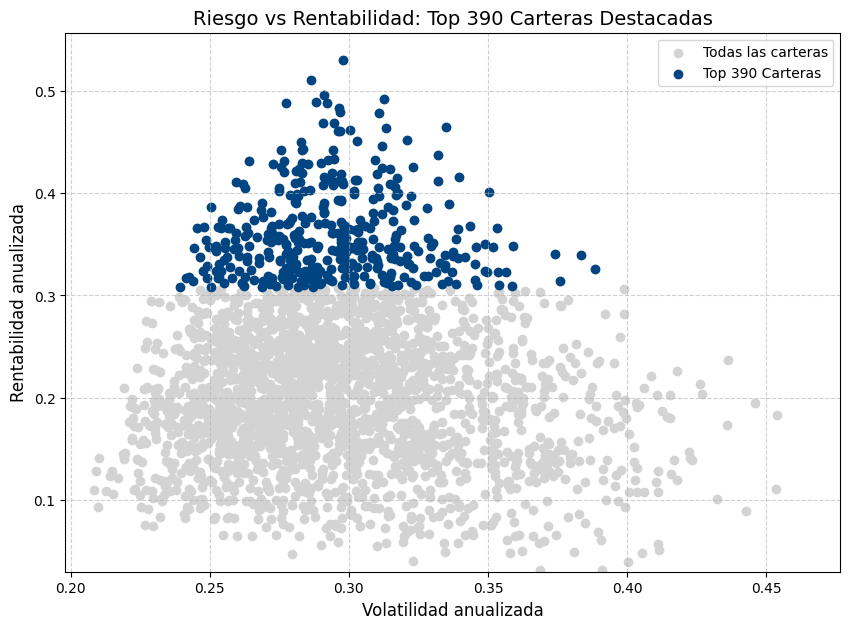

In [6]:
import matplotlib.pyplot as plt
top390 = cartera_simple.head(390)
plt.figure(figsize=(10,7))
plt.scatter(cartera_simple['volatilidad_anualizada'], cartera_simple['rentabilidad_anualizada'], 
            c='lightgray', label='Todas las carteras')
plt.scatter(top390['volatilidad_anualizada'], top390['rentabilidad_anualizada'], 
            c='#004481', label='Top 390 Carteras')
for i, row in top390.iterrows():
    activos = ', '.join(row['cartera'])
plt.xlim(cartera_simple['volatilidad_anualizada'].min() * 0.95, cartera_simple['volatilidad_anualizada'].max() * 1.05)
plt.ylim(cartera_simple['rentabilidad_anualizada'].min() * 0.95, cartera_simple['rentabilidad_anualizada'].max() * 1.05)
plt.title('Riesgo vs Rentabilidad: Top 390 Carteras Destacadas', fontsize=14)
plt.xlabel('Volatilidad anualizada', fontsize=12)
plt.ylabel('Rentabilidad anualizada', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

2º OPCIÓN: Correlación

In [7]:
import ast
def evaluar_carteras_desde_top(df_precios, df_top, risk_free_rate=0.01):
    if 'cartera' not in df_top.columns:
        raise ValueError("df_top debe contener la columna 'cartera' con las carteras a evaluar")
    carteras = []
    for v in df_top['cartera']:
        if isinstance(v, (list, tuple, set)):
            carteras.append(tuple(map(str, v)))
        elif isinstance(v, str):
            parsed = None
            try:
                parsed = ast.literal_eval(v)
            except Exception:
                parsed = None
            if isinstance(parsed, (list, tuple, set)):
                carteras.append(tuple(map(str, parsed)))
            else:
                parts = [p.strip() for p in v.split(',') if p.strip()]
                if len(parts) > 1:
                    carteras.append(tuple(map(str, parts)))
                else:
                    carteras.append((str(v),))
        else:
            try:
                carteras.append(tuple(map(str, list(v))))
            except Exception:
                carteras.append((str(v),))
    available = set(df_precios.columns.astype(str))
    carteras_validas = []
    carteras_descartadas = []
    for c in carteras:
        if all(sym in available for sym in c):
            carteras_validas.append(c)
        else:
            carteras_descartadas.append(c)
    if len(carteras_validas) == 0:
        raise ValueError("Ninguna cartera válida: comprueba que los símbolos de 'cartera' estén en df_precios.columns")
    returns = df_precios.pct_change().dropna()
    cov_anual = returns.cov() * 252
    corr_matrix = returns.corr()
    resultados = []
    for activos in carteras_validas:
        n = len(activos)
        pesos = np.array([1.0/n] * n)
        sub_returns = returns[list(activos)]
        port_daily_returns = sub_returns @ pesos
        rent_diaria_media = port_daily_returns.mean()
        rentabilidad_anualizada = (1 + rent_diaria_media) ** 252 - 1
        sub_cov = cov_anual.loc[list(activos), list(activos)]
        volatilidad_anualizada = np.sqrt(np.dot(pesos, np.dot(sub_cov, pesos.T)))
        rentabilidad_acumulada = (1 + port_daily_returns).prod() - 1
        sharpe = (rentabilidad_anualizada - risk_free_rate) / volatilidad_anualizada if volatilidad_anualizada > 0 else np.nan
        cumulative = (1 + port_daily_returns).cumprod()
        rolling_max = cumulative.cummax()
        drawdown = (cumulative - rolling_max) / rolling_max
        max_dd = drawdown.min()
        if n == 3:
            c_ab = corr_matrix.loc[activos[0], activos[1]]
            c_ac = corr_matrix.loc[activos[0], activos[2]]
            c_bc = corr_matrix.loc[activos[1], activos[2]]
            corrs = [c_ab, c_ac, c_bc]
            corr_alta = max(corrs)
            idx_alta = corrs.index(corr_alta)
            pares = [(activos[0], activos[1]), (activos[0], activos[2]), (activos[1], activos[2])]
            par_alta = pares[idx_alta]
            tercero = list(set(activos) - set(par_alta))[0]
            corr_tercero_1 = corr_matrix.loc[tercero, par_alta[0]]
            corr_tercero_2 = corr_matrix.loc[tercero, par_alta[1]]
            corr_media_tercero = float(np.mean([corr_tercero_1, corr_tercero_2]))
            score_corr = float(corr_alta - corr_media_tercero)
        else:
            corr_alta = np.nan
            corr_media_tercero = np.nan
            score_corr = np.nan
        resultados.append({
            'cartera': activos,
            'rentabilidad_anualizada': float(rentabilidad_anualizada),
            'volatilidad_anualizada': float(volatilidad_anualizada),
            'rentabilidad_acumulada': float(rentabilidad_acumulada),
            'sharpe': float(sharpe) if not np.isnan(sharpe) else np.nan,
            'drawdown_max': float(max_dd),
            'corr_mas_alta': float(corr_alta) if not np.isnan(corr_alta) else np.nan,
            'corr_media_tercero': float(corr_media_tercero) if not np.isnan(corr_media_tercero) else np.nan,
            'score_corr': float(score_corr) if not np.isnan(score_corr) else np.nan})
    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.sort_values(by=['score_corr', 'rentabilidad_anualizada'], ascending=[False, False]).reset_index(drop=True)
    print(f"Carteras evaluadas: {len(carteras_validas)}  |  descartadas por símbolos faltantes: {len(carteras_descartadas)}")
    if carteras_descartadas:
        print("Ejemplos descartados:", carteras_descartadas[:5])
    return df_resultados

In [8]:
carteras = evaluar_carteras_desde_top(df_limpio,top390,risk_free_rate=0.01)
carteras.head()

Carteras evaluadas: 390  |  descartadas por símbolos faltantes: 0


,cartera,rentabilidad_anualizada,volatilidad_anualizada,rentabilidad_acumulada,sharpe,drawdown_max,corr_mas_alta,corr_media_tercero,score_corr
0,"(AAPL, MMM, MSFT)",0.412629,0.302347,1.022666,1.331675,-0.282177,0.738265,0.246895,0.491370
1,"(CRM, GS, JPM)",0.327319,0.323213,0.719605,0.981763,-0.377398,0.849375,0.390051,0.459325
2,"(AAPL, AXP, JPM)",0.415735,0.339635,0.978247,1.194622,-0.411201,0.845541,0.427789,0.417752
3,"(AAPL, GS, JPM)",0.452221,0.320875,1.129208,1.378172,-0.394654,0.849375,0.466307,0.383068
4,"(AXP, CRM, GS)",0.338796,0.337533,0.736696,0.974114,-0.402952,0.769597,0.388684,0.380913


In [9]:
carteras

,cartera,rentabilidad_anualizada,volatilidad_anualizada,rentabilidad_acumulada,sharpe,drawdown_max,corr_mas_alta,corr_media_tercero,score_corr
0,"(AAPL, MMM, MSFT)",0.412629,0.302347,1.022666,1.331675,-0.282177,0.738265,0.246895,0.491370
1,"(CRM, GS, JPM)",0.327319,0.323213,0.719605,0.981763,-0.377398,0.849375,0.390051,0.459325
2,"(AAPL, AXP, JPM)",0.415735,0.339635,0.978247,1.194622,-0.411201,0.845541,0.427789,0.417752
3,"(AAPL, GS, JPM)",0.452221,0.320875,1.129208,1.378172,-0.394654,0.849375,0.466307,0.383068
4,"(AXP, CRM, GS)",0.338796,0.337533,0.736696,0.974114,-0.402952,0.769597,0.388684,0.380913
...,...,...,...,...,...,...,...,...,...
385,"(AAPL, MCD, PG)",0.308512,0.239367,0.758555,1.247090,-0.298510,0.496395,0.477023,0.019372
386,"(GS, HD, NKE)",0.372385,0.297102,0.894790,1.219733,-0.385952,0.613426,0.594934,0.018492
387,"(DIS, GS, V)",0.327921,0.306651,0.744349,1.036753,-0.401291,0.640657,0.628218,0.012439
388,"(DIS, MSFT, NKE)",0.391425,0.280810,0.980808,1.358303,-0.349882,0.509399,0.499975,0.009424


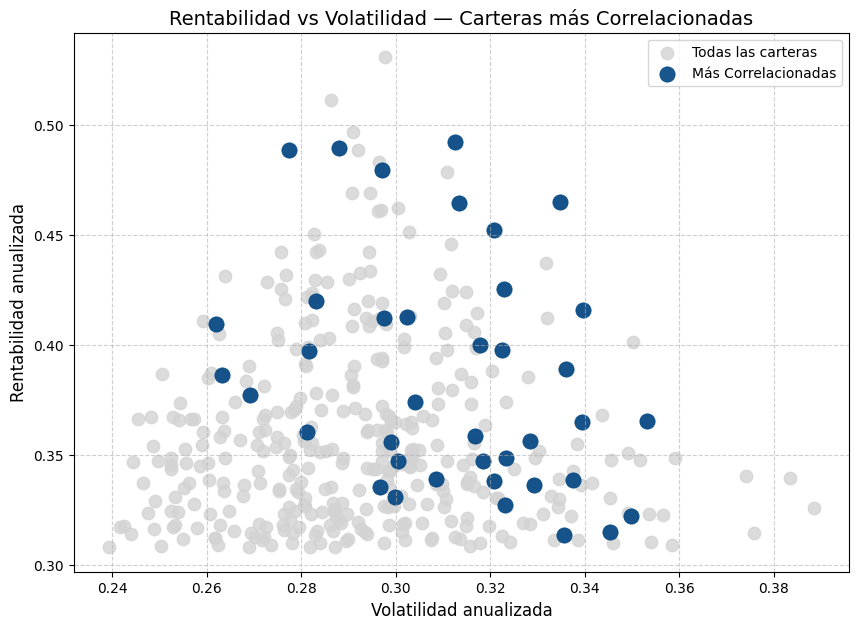

In [10]:
plt.figure(figsize=(10,7))

plt.scatter(carteras['volatilidad_anualizada'], carteras['rentabilidad_anualizada'],
            c='lightgray', s=80, alpha=0.8, label='Todas las carteras')

umbral_corr = carteras['score_corr'].quantile(0.9)
mas_corr = carteras[carteras['score_corr'] >= umbral_corr]

plt.scatter(mas_corr['volatilidad_anualizada'], mas_corr['rentabilidad_anualizada'],
            c="#004481", s=120, alpha=0.9,
            linewidths=0.6, label='Más Correlacionadas')

plt.title('Rentabilidad vs Volatilidad — Carteras más Correlacionadas', fontsize=14)
plt.xlabel('Volatilidad anualizada', fontsize=12)
plt.ylabel('Rentabilidad anualizada', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

2º OPCIÓN: Métricas Sharpe

In [11]:
mas_corr

,cartera,rentabilidad_anualizada,volatilidad_anualizada,rentabilidad_acumulada,sharpe,drawdown_max,corr_mas_alta,corr_media_tercero,score_corr
0,"(AAPL, MMM, MSFT)",0.412629,0.302347,1.022666,1.331675,-0.282177,0.738265,0.246895,0.491370
1,"(CRM, GS, JPM)",0.327319,0.323213,0.719605,0.981763,-0.377398,0.849375,0.390051,0.459325
2,"(AAPL, AXP, JPM)",0.415735,0.339635,0.978247,1.194622,-0.411201,0.845541,0.427789,0.417752
3,"(AAPL, GS, JPM)",0.452221,0.320875,1.129208,1.378172,-0.394654,0.849375,0.466307,0.383068
4,"(AXP, CRM, GS)",0.338796,0.337533,0.736696,0.974114,-0.402952,0.769597,0.388684,0.380913
5,"(AAPL, AXP, CVX)",0.315010,0.345325,0.655013,0.883254,-0.439246,0.761057,0.399296,0.361761
6,"(AAPL, CAT, MSFT)",0.488446,0.277377,1.325639,1.724893,-0.303350,0.738265,0.384560,0.353704
7,"(CAT, CRM, MSFT)",0.360440,0.281194,0.877789,1.246259,-0.315063,0.684151,0.334391,0.349760
8,"(AAPL, CAT, DOW)",0.397699,0.322404,0.941682,1.202528,-0.410829,0.727362,0.381984,0.345378
9,"(AAPL, BA, MSFT)",0.365598,0.353196,0.793592,1.006800,-0.469659,0.738265,0.393218,0.345047


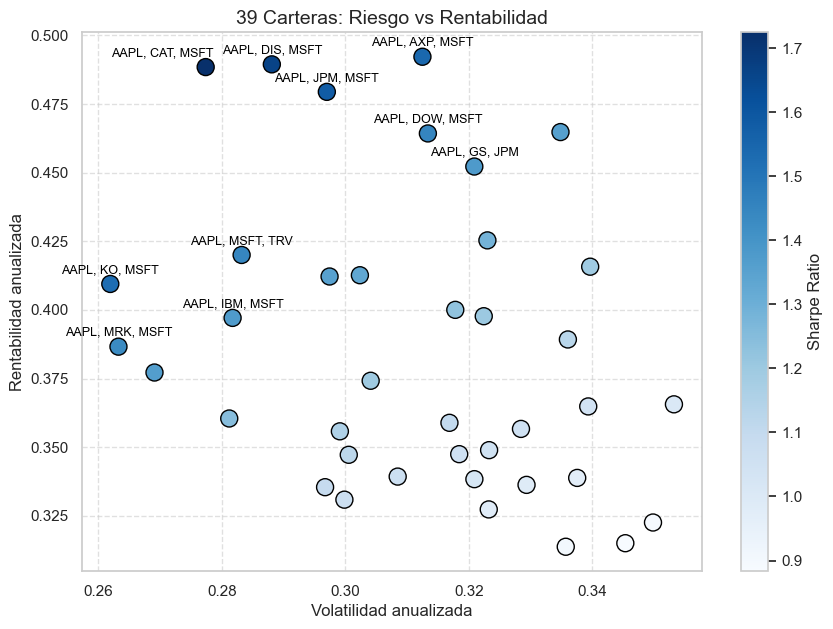

In [38]:
plt.figure(figsize=(10,7))
plt.scatter(mas_corr['volatilidad_anualizada'], mas_corr['rentabilidad_anualizada'], 
            c=mas_corr['sharpe'], cmap='Blues', s=150, edgecolor='black')
top = mas_corr.nlargest(10, 'sharpe')
for i, row in top.iterrows():
    activos = ', '.join(row['cartera'])
    x = row['volatilidad_anualizada']
    y = row['rentabilidad_anualizada'] + 0.003  
    if tuple(row['cartera']) == ('AAPL', 'CAT', 'MSFT'):
        x -= 0.007 
    plt.text(x, y, activos, fontsize=9, ha='center', va='bottom', color='black')
plt.title('39 Carteras: Riesgo vs Rentabilidad', fontsize=14)
plt.xlabel('Volatilidad anualizada', fontsize=12)
plt.ylabel('Rentabilidad anualizada', fontsize=12)
plt.colorbar(label='Sharpe Ratio')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

3º OPCIÓN: Métricas Drawdown

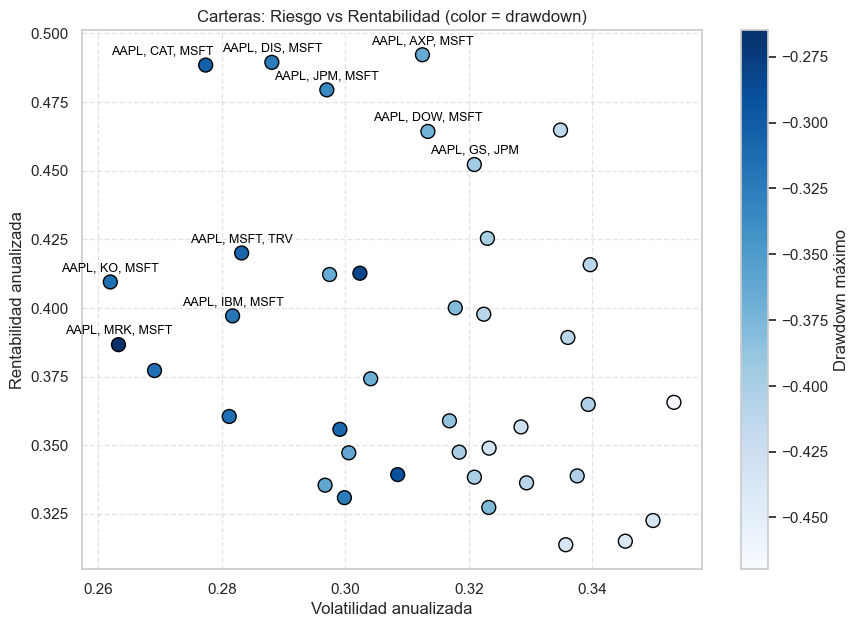

In [39]:
plt.figure(figsize=(10,7))
plt.scatter(
    mas_corr['volatilidad_anualizada'],mas_corr['rentabilidad_anualizada'],
    c=mas_corr['drawdown_max'],cmap='Blues',s=100,edgecolor='black')
for i, row in top.iterrows():
    activos = ', '.join(row['cartera'])
    x = row['volatilidad_anualizada']
    y = row['rentabilidad_anualizada'] + 0.003  
    if tuple(row['cartera']) == ('AAPL', 'CAT', 'MSFT'):
        x -= 0.007 
    plt.text(x, y, activos, fontsize=9, ha='center', va='bottom', color='black')
plt.colorbar(label='Drawdown máximo')
plt.xlabel('Volatilidad anualizada')
plt.ylabel('Rentabilidad anualizada')
plt.title('Carteras: Riesgo vs Rentabilidad (color = drawdown)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

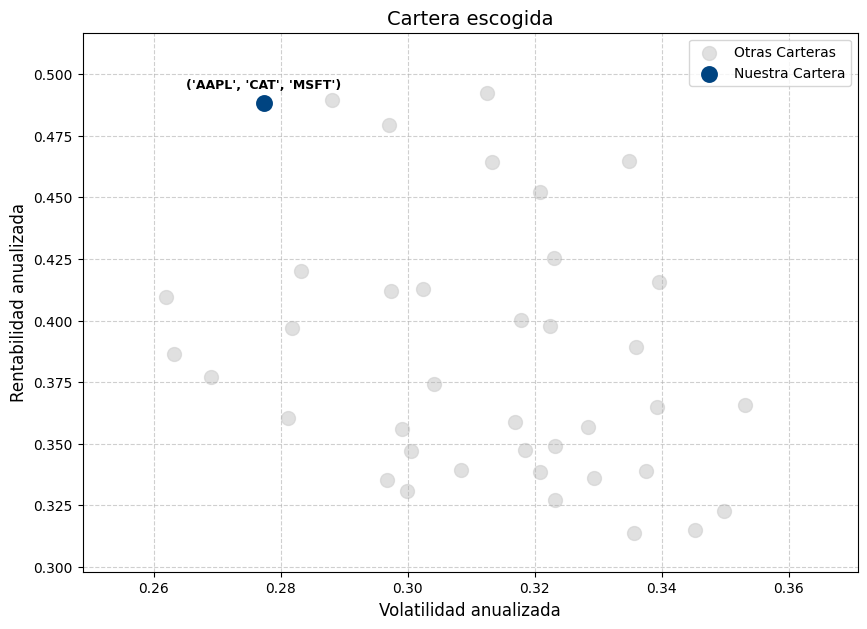

In [14]:
plt.figure(figsize=(10,7))
plt.scatter(mas_corr['volatilidad_anualizada'], mas_corr['rentabilidad_anualizada'],
            c='lightgray', s=100, alpha=0.7, label='Otras Carteras')

cartera_objetivo = ('AAPL', 'CAT', 'MSFT')
mask = mas_corr['cartera'] == cartera_objetivo

plt.scatter(mas_corr.loc[mask, 'volatilidad_anualizada'],
            mas_corr.loc[mask, 'rentabilidad_anualizada'],
            c='#004481', s=120, alpha=1.0, linewidths=1.2,
            label='Nuestra Cartera')

for idx in mas_corr.loc[mask].index:
    x = mas_corr.loc[idx, 'volatilidad_anualizada']
    y = mas_corr.loc[idx, 'rentabilidad_anualizada']
    plt.annotate(f"{cartera_objetivo}", 
                 (x, y),
                 textcoords="offset points", xytext=(0,10), ha='center',
                 fontsize=9, color='black', fontweight='bold')

plt.xlim(mas_corr['volatilidad_anualizada'].min() * 0.95, mas_corr['volatilidad_anualizada'].max() * 1.05)
plt.ylim(mas_corr['rentabilidad_anualizada'].min() * 0.95, mas_corr['rentabilidad_anualizada'].max() * 1.05)

plt.title('Cartera escogida', fontsize=14)
plt.xlabel('Volatilidad anualizada', fontsize=12)
plt.ylabel('Rentabilidad anualizada', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [15]:
df_cartera = df_limpio[list(cartera_objetivo)]
df_cartera.to_csv('Datos/Transformados/cartera.csv', index=True)

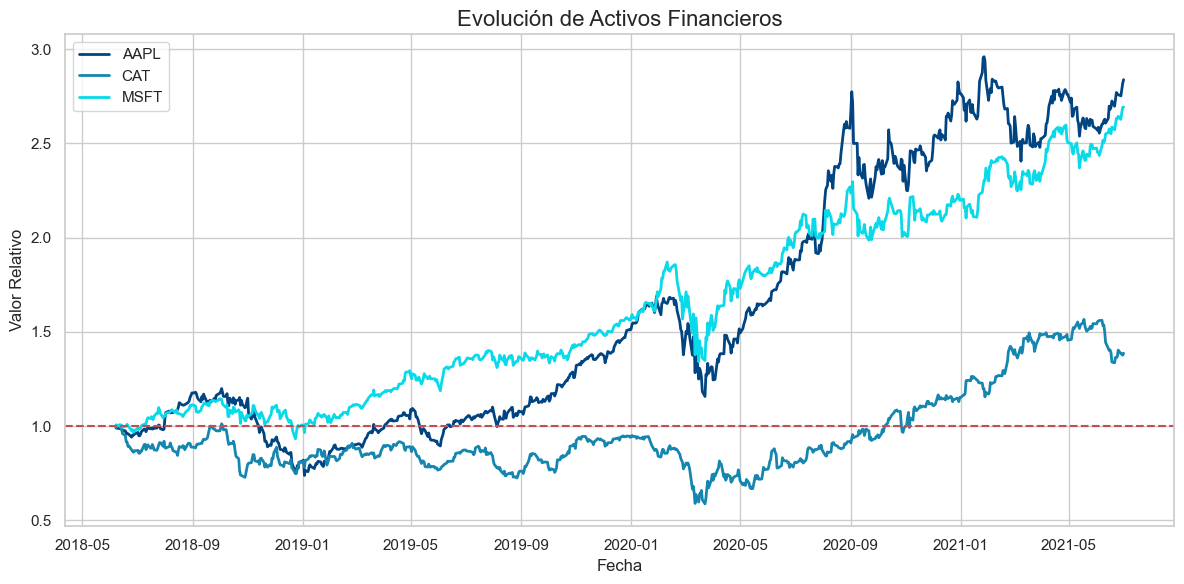

In [16]:
bbva_palette = [
    '#004481',  
    "#1586AF",  
    "#08DAE9",  
    '#F58220',  
    '#FDBD2C',  
    '#6c757d',  
]
df_reb = (df_cartera / df_cartera.iloc[0])
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6)) 
for i, column in enumerate(df_reb.columns):
    color_a_usar = bbva_palette[i % len(bbva_palette)]
    plt.plot(df_reb.index, 
             df_reb[column], 
             label=column, 
             color=color_a_usar,  
             linewidth=2)
plt.axhline(y=1, color='r', linestyle='--')
plt.title('Evolución de Activos Financieros', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor Relativo', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show() 
# Tiene sesgo escoger estas porque son las que mejor se comportan con la crisis de la pandemia. Será para el que tiene el objetivo de invertir a corto plazo. 

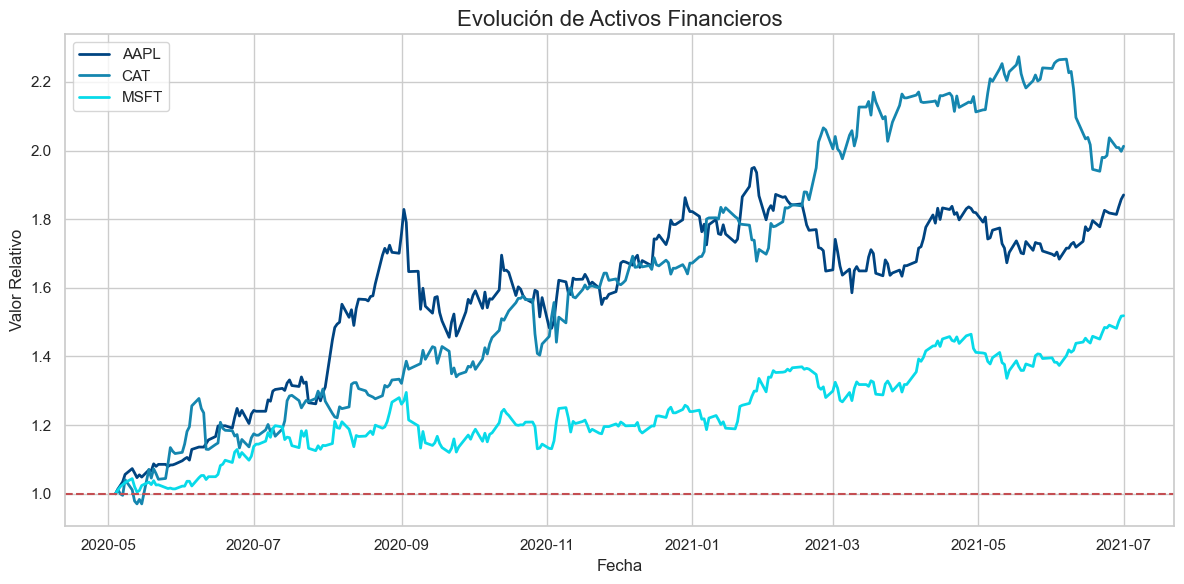

In [17]:
df_rebasado = df_cartera[df_cartera.index > '2020-05-01']
df_rebasado = (df_rebasado / df_rebasado.iloc[0])
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6)) 
for i, column in enumerate(df_rebasado.columns):
    color_a_usar = bbva_palette[i % len(bbva_palette)]
    plt.plot(df_rebasado.index, 
             df_rebasado[column], 
             label=column, 
             color=color_a_usar,  
             linewidth=2)
plt.axhline(y=1, color='r', linestyle='--')
plt.title('Evolución de Activos Financieros', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor Relativo', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show() 